In [1]:
# Clear variables
%reset

## Libraries

In [2]:
import pandas as pd
import pm4py
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-11.0.0-win64/bin/'
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


## Variant Analysis


In [3]:
filtered_log_df = pd.read_csv('data\\sepsis_filtered_data_2024-06-13_14-06-03.csv', sep=',')
filtered_log_df['time:timestamp']= pd.to_datetime(filtered_log_df['time:timestamp'])
filtered_log_df['case:concept:name'] = filtered_log_df['case:concept:name'].astype(str)

In [4]:
filtered_log = log_converter.apply(filtered_log_df)
variants = pm4py.get_variants(filtered_log)
variants_lengths = {key: len(value) for key, value in variants.items()}
sorted_variants_lengths = dict(sorted(variants_lengths.items(), key=lambda item: item[1], reverse=True))
for i, (key, length) in enumerate(sorted_variants_lengths.items()):
    print(f"Number of cases of each variant: {length} '\n' {key} ")
    if i == 10:  # Stop after printing the first 5 elements
        break

Number of cases of each variant: 11 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'LacticAcid', 'Leucocytes', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 8 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 7 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'CRP', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Release A') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Leucocytes', 'CRP', 'Release A') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'CRP'

In [5]:
# Between Filter

a = pm4py.filter_between(filtered_log_df, "ER Registration", "ER Triage")
b = pm4py.filter_between(filtered_log_df, "ER Triage", "ER Sepsis Triage")
c = pm4py.filter_between(filtered_log_df, "ER Registration", "ER Sepsis Triage")
# y = pm4py.filter_between(filtered_log_df, "CRP", "Leucocytes")
print(len(a['case:concept:name'].unique()))
print(len(b['case:concept:name'].unique()))
print(len(c['case:concept:name'].unique()))
print('\n')

661
654
661




#### Rework Filter

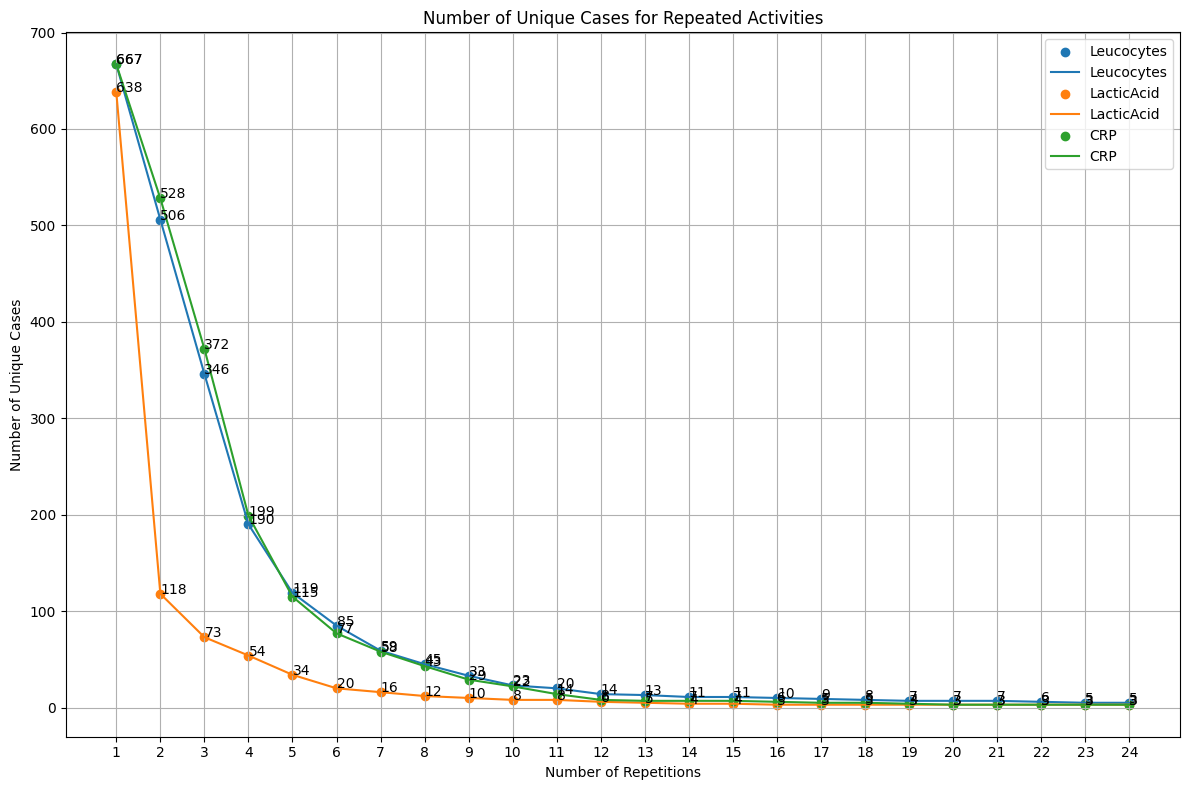

In [11]:
# Define the range
min_value = 1
max_value = 25

# Generate the array
repetitions_num = np.arange(min_value, max_value, 1)

# List of columns to process
columns = ["Leucocytes", "LacticAcid", "CRP"]

# Dictionary to store the results
results = {column: [] for column in columns}

# Assuming filtered_log_df is your DataFrame
for column in columns:
    for i in repetitions_num:
        d = pm4py.filter_activities_rework(filtered_log_df, column, i)
        results[column].append(len(d['case:concept:name'].unique()))

# Plotting the results for each column
plt.figure(figsize=(12, 8))

for column in columns:
    plt.scatter(repetitions_num, results[column], label=column)
    plt.plot(repetitions_num, results[column], label=column)
    for rep_num, result in zip(repetitions_num, results[column]):
        plt.annotate(result, (rep_num, result))

plt.xlabel('Number of Repetitions')
plt.ylabel('Number of Unique Cases')
plt.title('Number of Unique Cases for Repeated Activities')
plt.legend()
plt.xticks(ticks=np.arange(min_value, max_value, 1))  # Adjust ticks for better readability
plt.tight_layout()
plt.grid()
# Show the plot
plt.show()

### Segments

In [7]:
from pm4py.algo.filtering.pandas.attributes import attributes_filter

filtered_log_df_leuc = attributes_filter.apply_numeric_events(filtered_log_df, 4.0, 12.0,
                                                              parameters={
                                                                  attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                                  attributes_filter.Parameters.ATTRIBUTE_KEY: "Leucocytes"})

#
# filtered_df_cases = attributes_filter.apply_numeric(df, 34, 36,
#                                              parameters={attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name", attributes_filter.Parameters.ATTRIBUTE_KEY: "amount"})
#
# filtered_df_cases = attributes_filter.apply_numeric(df, 34, 500,
#                                              parameters={attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name", attributes_filter.Parameters.ATTRIBUTE_KEY: "amount",
#                                                          attributes_filter.Parameters.STREAM_FILTER_KEY1: "concept:name",
#                                                              attributes_filter.Parameters.STREAM_FILTER_VALUE1: "Add penalty"})

## DFG - discovery algorithm

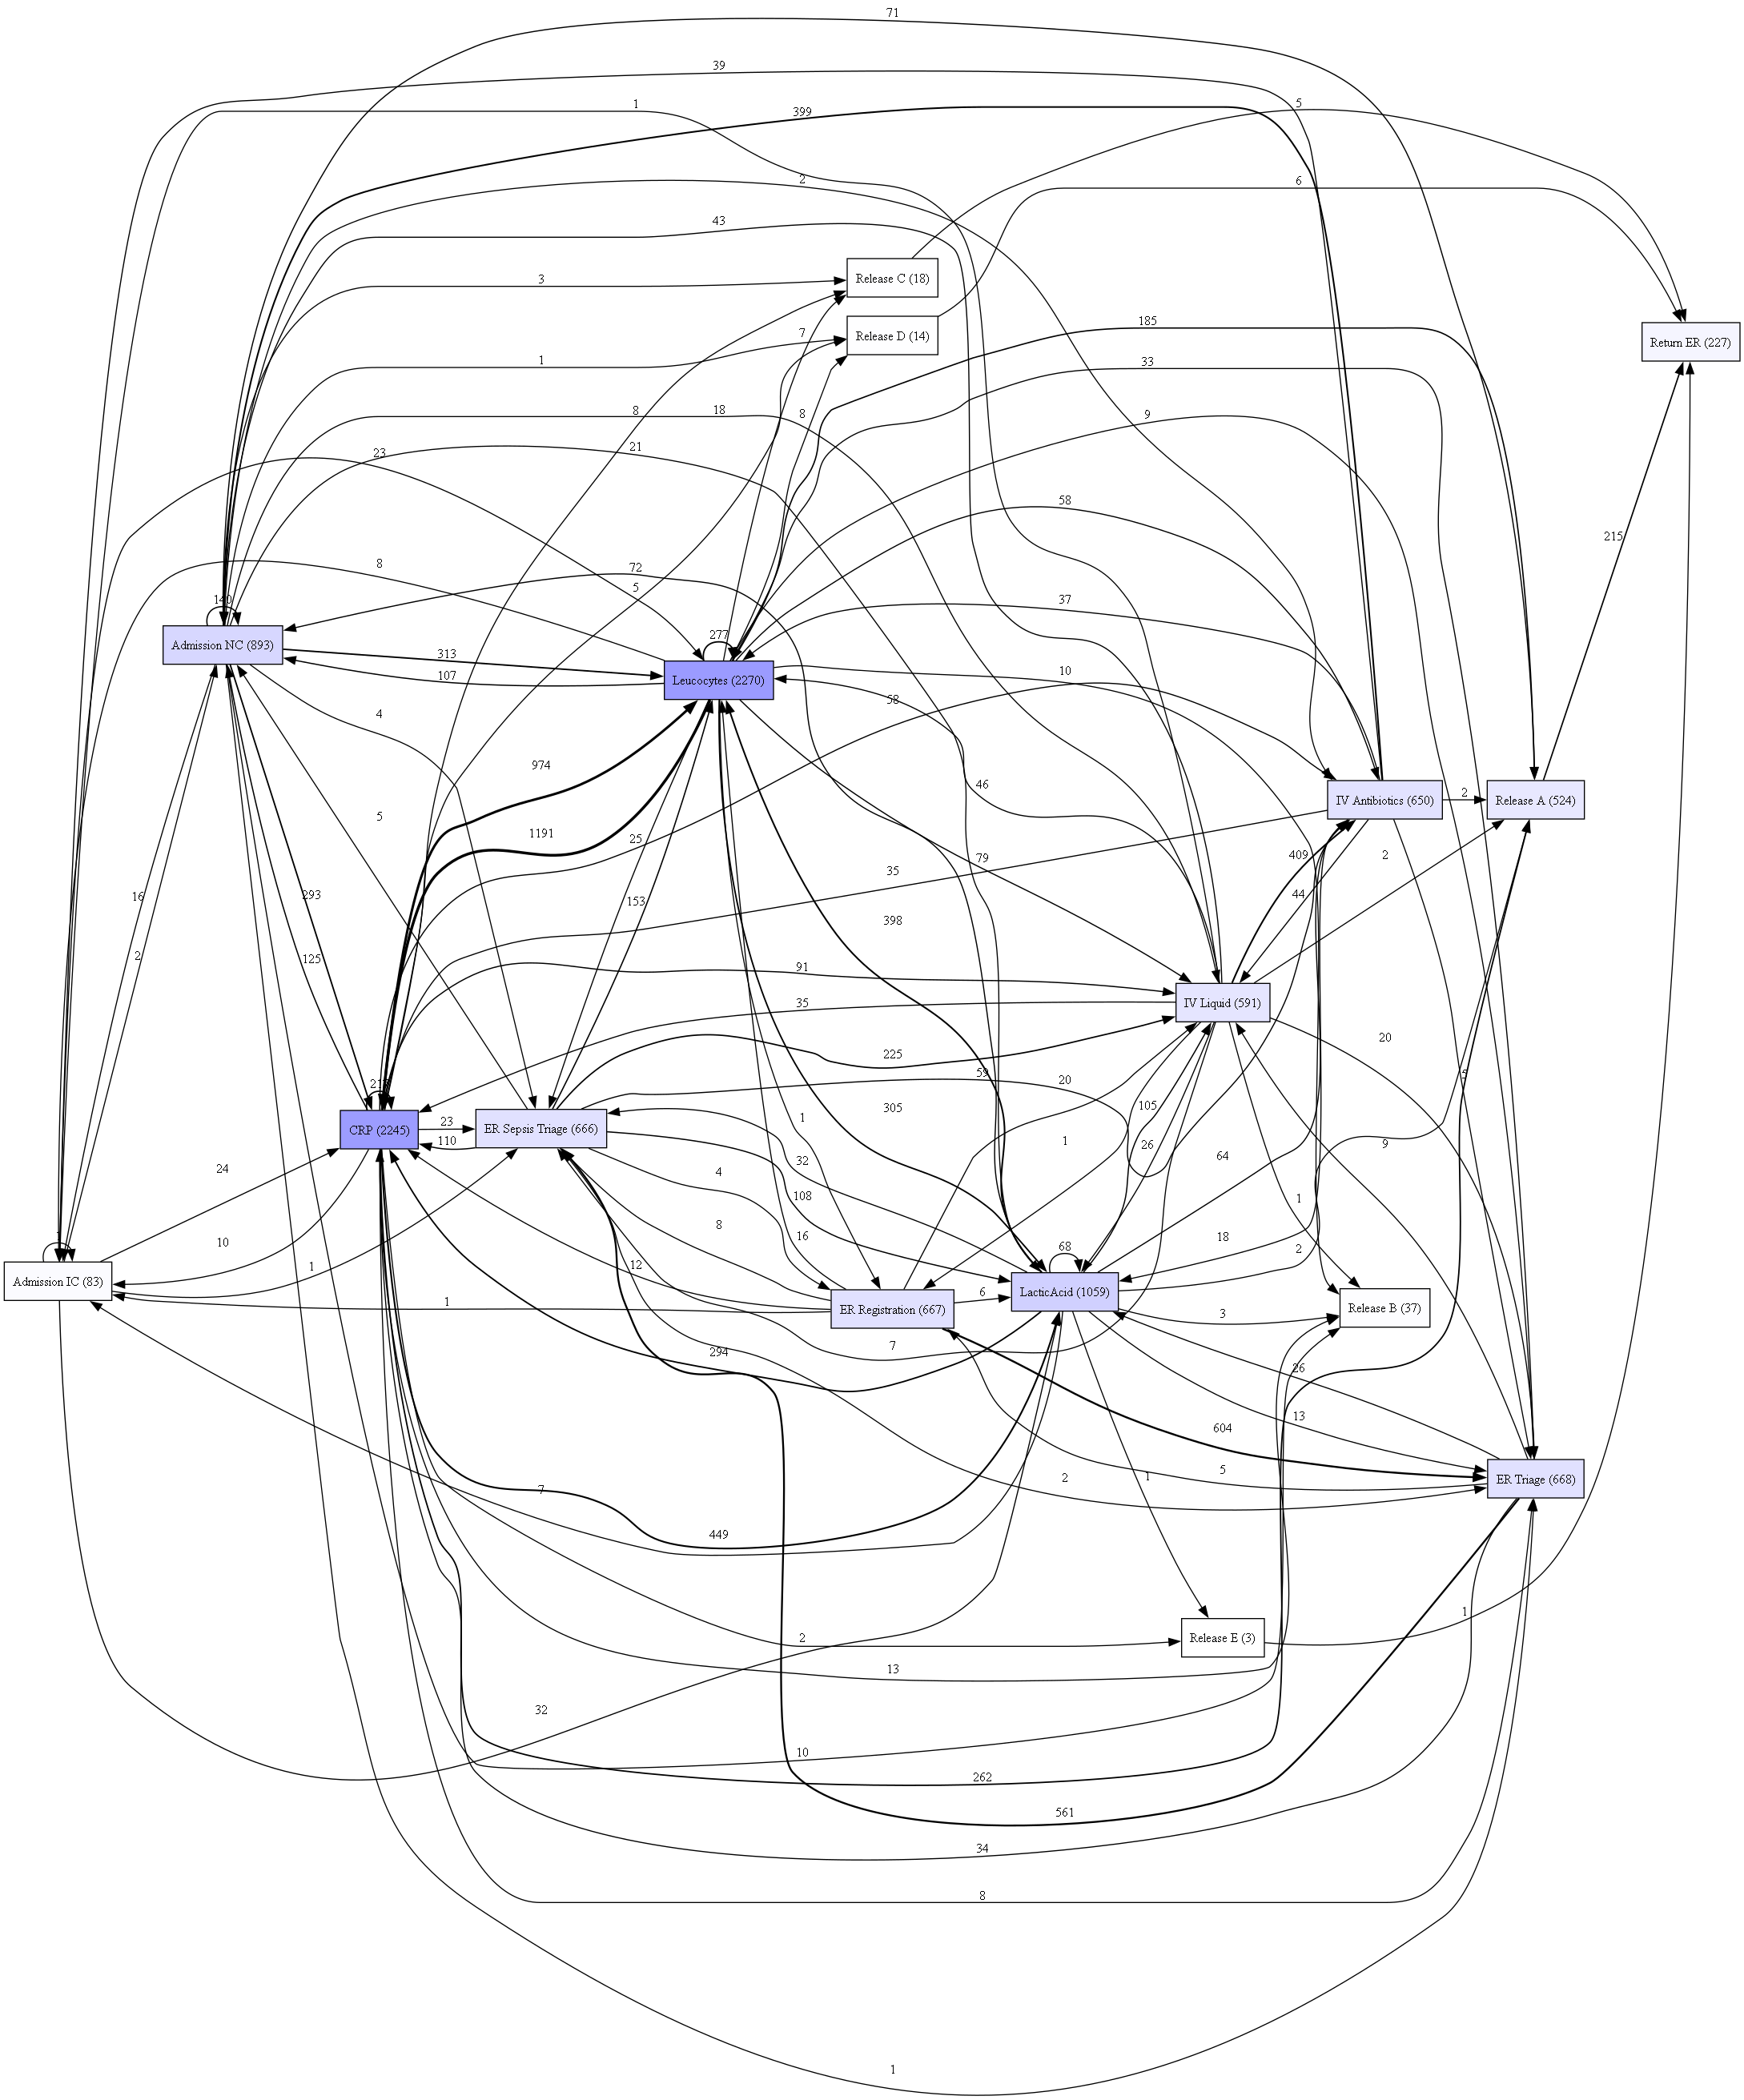

In [8]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization

## Convert to log format
filtered_log = log_converter.apply(filtered_log_df)
#Create graph from log
dfg = dfg_discovery.apply(filtered_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=filtered_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Inductive Miner

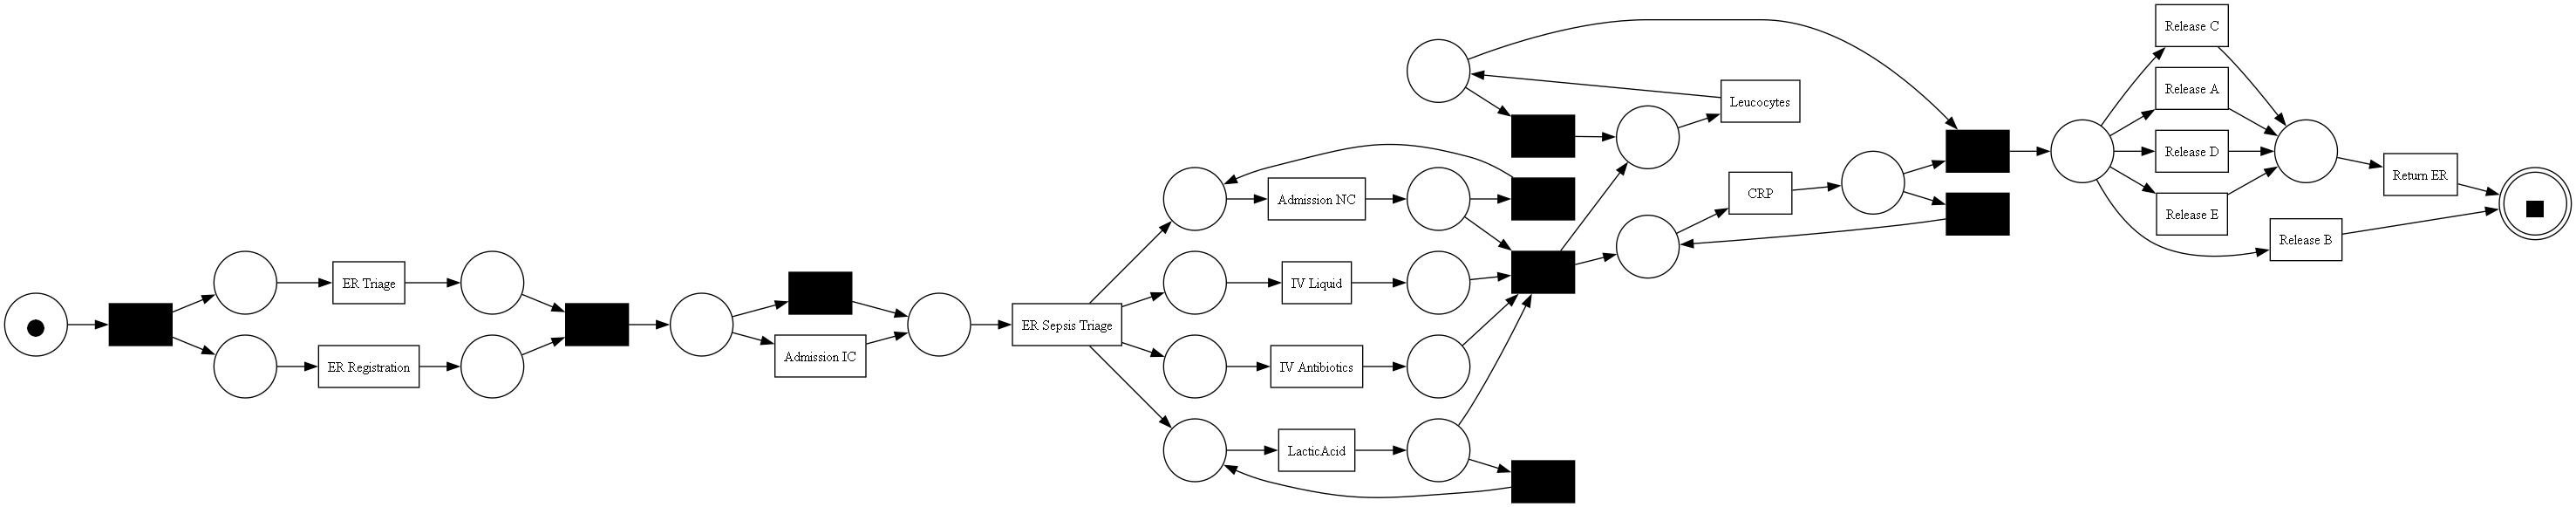

In [9]:
# Discover the model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log_df, noise_threshold=0.7)
pm4py.view_petri_net(net, im, fm, format='png')

In [10]:
pm4py.get_start_activities(filtered_log_df, activity_key='concept:name')
pm4py.get_end_activities(filtered_log_df, activity_key='concept:name')

{'Release A': 309,
 'IV Antibiotics': 71,
 'Return ER': 227,
 'Release B': 37,
 'Release E': 2,
 'Release C': 13,
 'Release D': 8}